In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
# PreProcessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Splitting Data
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score

In [20]:
df=pd.read_csv('hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


- Business objective apa yang hendak dicapai melalui proyek ini?
    + Mengetahui seberapa besar kemungkinan pengunjung akan membatalkan booking kamar hotelnya
- Keluaran (output) seperti apa yang akan dihasilkan dari proyek ini dan bagaimana end user atau stakeholder akan memanfaatkan keluaran tersebut?
    + pengelompokan antara dicancel atau tidaknya suatu booking kamar hotel
- Machine learning task apa yang akan dikerjakan? (supervised/unsupervised learning, classification/regression/clustering/dimensionality reduction problem dsb.) 
- Performance measure apa yang akan digunakan di dalam proyek ini?
    + AUC Score
- Risiko seperti apa yang mungkin diakibatkan oleh kesalahan prediksi dari model Anda? ketidaktepatan hasil dari klasifikasi data yang telah ditest berdasarkan data training


## EDA

In [21]:
# Categorize data into two types
numerical_data = df.select_dtypes(include=['int64', 'float64']).columns
categorical_data = df.select_dtypes(include=['object']).columns

In [22]:
hotel_eda = df.copy()
hotel_eda['hotel'].value_counts()

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

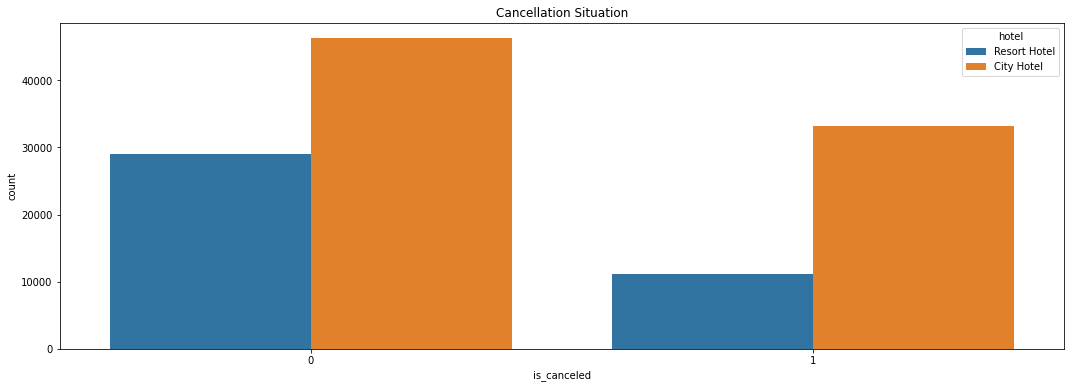

In [23]:
plt.figure(figsize=(18,6))
sns.countplot(x='is_canceled', hue = 'hotel', data= hotel_eda)
plt.title('Cancellation Situation')
plt.show()

City Hotel memiliki cancel booking tertinggi dan juga tidak cancel yang tinggi.

In [24]:
hotel_eda['is_canceled'].value_counts()/df.shape[0]*100

0    62.958372
1    37.041628
Name: is_canceled, dtype: float64

Perbedaan ratio antara canceled dan tidak canceled menunjukan imbalanced data:
Not Canceled: 62,96%
Canceled: 37,04%

### Customer Profiling

In [25]:
hotel_eda['all_child'] = hotel_eda['children'] + hotel_eda['babies']
pd.crosstab(hotel_eda['adults'], hotel_eda['all_child'], margins=True, margins_name = 'Total')

all_child,0.0,1.0,2.0,3.0,9.0,10.0,Total
adults,,,,,,,
0,180,4,205,14,0,0,403
1,22577,286,157,6,1,0,23027
2,81557,4658,3369,91,0,2,89677
3,5665,495,41,0,0,0,6201
4,59,3,0,0,0,0,62
5,2,0,0,0,0,0,2
6,1,0,0,0,0,0,1
10,1,0,0,0,0,0,1
20,2,0,0,0,0,0,2


- Dalam data ini, saya menggabungkan anak anak, bayi kedalam kolom semua anak

#### Adults
- Judging from the data above, as many as 4175 adults came and without bring any children as many as 3777. There is a possibility that they have a business purpose or a couple who are on honeymoon.
- Menilai dari data yang ada, sebanyak 4175 orang dewasa datang dan tidak membawa awal senbanyak 3777. Ini paling masuk akal mungkin saja mereka punya bisnis tersendiri
- Ditempat kedua ada orang dewasa yang daatang terakhir kalinya sebanyak 654 people dan yang tidak membawa anak anak sebanyak 642 642 people. It is possible to have a business purpose.
- For adults who come more than 4 adults, no one brings a single child. There is the possibility of having a business trip or traveling.
- Untuk orang dewasa yang datang tidak lebih dari 4

#### All Child
- In the data above, the majority of adults who came without bringing children were 4560, followed by those who brought 1 child as many as 237 adults and 2 children as many as 201 adults.
- Menurut datset ini adalah paling banyak orang dewasa yang tidak membawa anak sebesar 4560, diikuti dengan yang membawa 1 anak sebesar 237

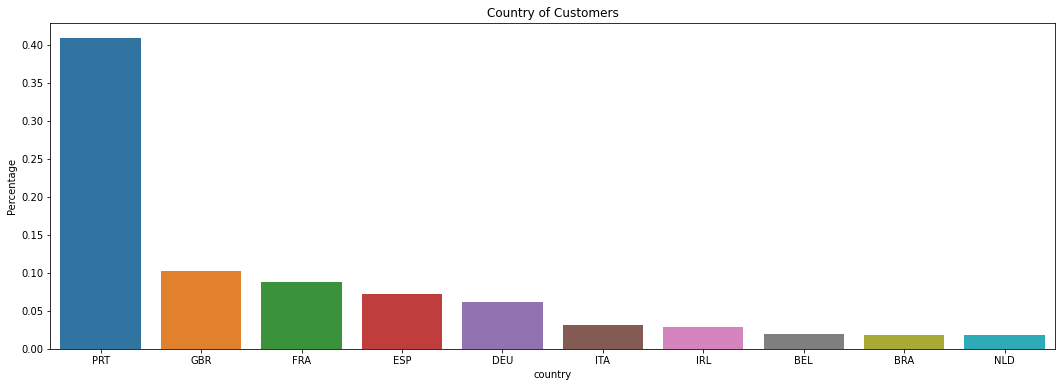

In [26]:
plt.figure(figsize=(18,6))
country_booking = hotel_eda['country'].value_counts(normalize=True).rename_axis('country').reset_index(name='Percentage')
sns.barplot(x='country', y='Percentage', data=country_booking.head(10))
plt.title('Country of Customers')
plt.show()

- Categories are represented in the ISO 3155–3:2013 format.
- PRT or Portugal has the most booking demand based on the data (more than 60%). It is pretty obvious because if we trace to the publication page, the description tells us that the data source locations are from hotels located in Portugal.

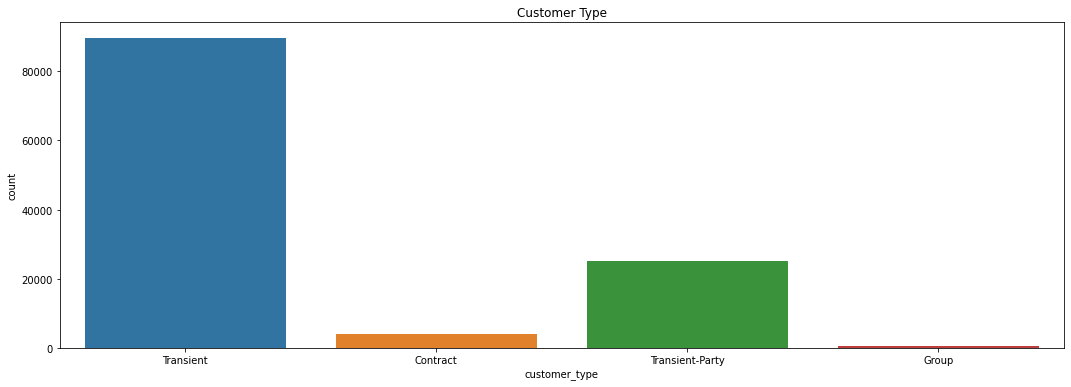

In [27]:
plt.figure(figsize=(18,6))
sns.countplot(x='customer_type', data= hotel_eda)
plt.title('Customer Type')
plt.show()

In [28]:
hotel_eda['customer_type'].value_counts()/len(hotel_eda['customer_type'])*100

Transient          75.059050
Transient-Party    21.043638
Contract            3.414021
Group               0.483290
Name: customer_type, dtype: float64

Type of booking, assuming one of four categories:
- Contract, when the booking has an allotment or other type of contract associated to it
- Group, when the booking is associated to a group
- Transient, when the booking is not part of a group or contract, and is not associated to other transient booking
- Transient-party, when the booking is transient, but is associated to at least other transient booking

From the graph:
- Transient as much as 75.05%
- Transient-party as much as 21.04%
- Contract as much as 3.41%
- Group as much as 0.48%

Most of customers is Transient, means they are walk-in guests, last-minute or bookers, or simply people that require a very short-term stay in your facility. Transient customers are one of the major market segments consist of individuals or groups.

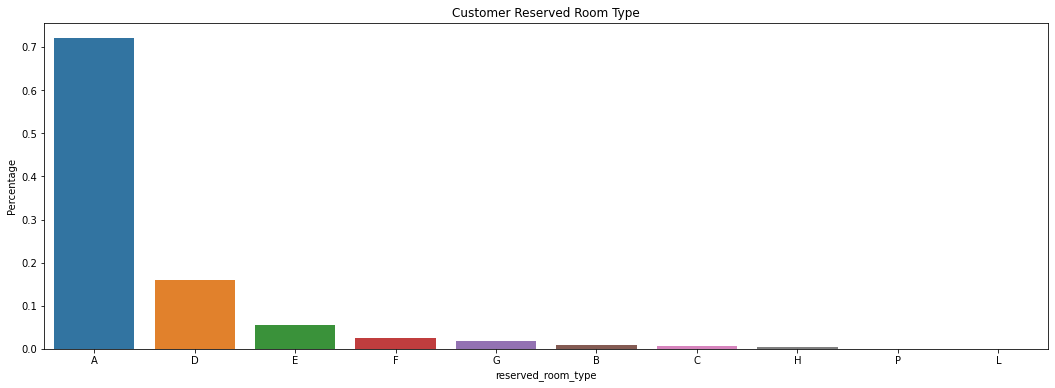

In [29]:
plt.figure(figsize=(18,6))
room_booking = hotel_eda['reserved_room_type'].value_counts(normalize=True).rename_axis('reserved_room_type').reset_index(name='Percentage')
sns.barplot(x='reserved_room_type', y='Percentage', data= room_booking)
plt.title('Customer Reserved Room Type')
plt.show()

In [30]:
hotel_eda['meal'].value_counts()/len(hotel_eda['meal'])*100

BB           77.318033
HB           12.114080
SC            8.920345
Undefined     0.979144
FB            0.668398
Name: meal, dtype: float64

Type of meal booked. Categories are presented in standard hospitality meal packages: 
- BB means Bed & Breakfast as much as 77.31%
- HB means Half board (breakfast and one other meal – usually dinner) as much as 12.11%
- FB means Full board (breakfast, lunch and dinner) as much as 0.66%
- Undefined/SC means no meal as much as 9.89%

Most customers prefer to book include Breakfast, which's the usual complimentary if someone wants to book a hotel. In case they don't have time to find breakfast outside the hotel. Some of them around 12.11% book with another meal, usually dinner. Them who came with business interests can get more resting time to not find any dinner outside hotel anymore.

#### Deposit Type for Market Segment
- The highest book is using Online TA, with No Deposit. While Groups and Offline TA/TO are next with Refundable and Non refund. In this era, it will be easy to book a hotel using Online TA, especially most Online TA offers the customers without deposit facility. Customers can choose any type of room up to any special request by Online TA.
- Looking at Offline TA/TO and Groups, the situations where the deposit was received were only in the scenarios where the groups came. It is quite logical to apply a deposit for a large number of customers who will fill important amount of the hotel capacity.

#### Cancellation for Market Segment
- The highest cancellation book is using Online TA. Most of Online TA give a customers previllege to cancel without any charge apply. Second, Groups segment has cancellation rate around 50%.

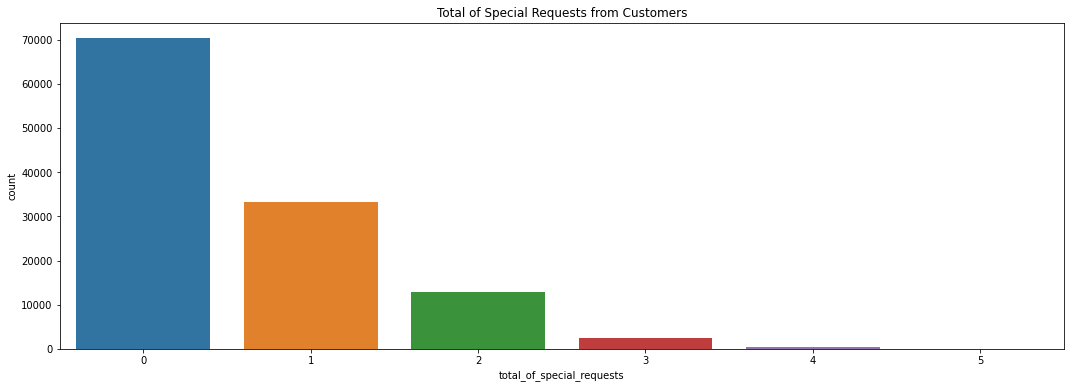

In [31]:
plt.figure(figsize=(18,6))
sns.countplot(x='total_of_special_requests', data= hotel_eda)
plt.title('Total of Special Requests from Customers')
plt.show()

In [32]:
def confusio_matrix(y_test, y_predicted):
    
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(10,10))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [33]:
df.isna().sum()/len(df)*100

hotel                              0.000000
is_canceled                        0.000000
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
children                           0.003350
babies                             0.000000
meal                               0.000000
country                            0.408744
market_segment                     0.000000
distribution_channel               0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                    

There are missing values and it will be processed on ColumnTransformer

*Preprocessing Scheme*

- OneHot: hotel, meal, market_segment, distribution_channel, reserved_room_type, deposit_type, customer_type
- Binary:
    * mode: country (country column more than 10 countries, soI decide to use binary)
- Mode Impute: children
- PassThrough: adults, babies, booking_changes, days_in_waiting_list, required_car_parking_spaces, total_of_special_requests
- Target: is_canceled
- No need to scale the data because there isn't any interval nominal between columns

Text(0.5, 1.0, 'Heat map of numerical correlation')

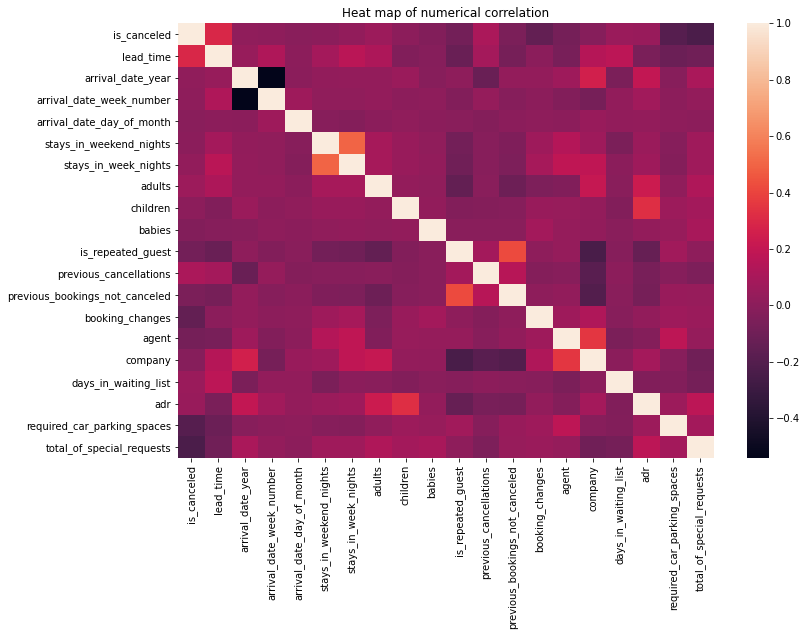

In [34]:
# Declare variable for keeping selected categorical features
selected_num = []

# Explore corrlation of numerical variables
plt.figure(figsize= (12,8))
features_corr = df[numerical_data].corr()
sns.heatmap(features_corr)

# Select features from numerical features
sig_features = features_corr['is_canceled'].sort_values().drop('is_canceled', axis=0)
selected_num.extend(sig_features.head(3).index.tolist())
selected_num.extend(sig_features.tail(3).index.tolist())
plt.title('Heat map of numerical correlation')

In [35]:
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# Declare variable for keeping selected numerical features
selected_cate = []

# Explore chi-square of categorical variables
for cat in categorical_data:
    contingency_tab = pd.crosstab(df[cat], df['is_canceled'])
    stat, p, dof, expected = chi2_contingency(contingency_tab)
    # Select features with p-value less than 0.05     
    if p < 0.05 and cat != 'reservation_status':
        selected_cate.append(cat)
    print('p-value of {} is {}'.format(cat, p))

p-value of hotel is 0.0
p-value of arrival_date_month is 3.671822609327152e-119
p-value of meal is 1.3212351959124216e-64
p-value of country is 0.0
p-value of market_segment is 0.0
p-value of distribution_channel is 0.0
p-value of reserved_room_type is 1.121956218424043e-133
p-value of assigned_room_type is 0.0
p-value of deposit_type is 0.0
p-value of customer_type is 0.0
p-value of reservation_status is 0.0
p-value of reservation_status_date is 0.0


In [36]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from category_encoders import OneHotEncoder
from sklearn.compose import ColumnTransformer

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

selected_features = selected_cate.copy()
selected_cate.remove('arrival_date_month')

# Deine pipeline for transforming each feaure type separately
preprocessor = ColumnTransformer([
        ('scaler', StandardScaler(), pd.Index(selected_num)),
        ('one_hot', OneHotEncoder(), pd.Index(selected_cate)),
        ('ordinal_enc', OrdinalEncoder(categories= [months]), pd.Index(['arrival_date_month']))
])

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import svm

# Define model training pipelines
lgs = Pipeline([('preprocess', preprocessor),
                ('logistic', LogisticRegression(max_iter=300))])

svm = Pipeline([('preprocess', preprocessor),
                ('svm', svm.SVC(max_iter=300))])

tree = Pipeline([('preprocess', preprocessor),
                ('decisionTree', DecisionTreeClassifier())])

In [39]:
X = df.drop(['is_canceled'], axis=1)
y = df['is_canceled']

# Split train test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 3)

## Modelling

In [ ]:
*Define Model*
- Me 3 basic models to predict:
    * Logistic Regression
    * SVM
    * DecisionTree

### Cross Validation

In [40]:
print('Selected categorical features: {}'.format(selected_cate))
print('Selected numerical features: {}'.format(selected_num))
selected_features =  selected_num + selected_cate + ['arrival_date_month']

Selected categorical features: ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status_date']
Selected numerical features: ['total_of_special_requests', 'required_car_parking_spaces', 'booking_changes', 'adults', 'previous_cancellations', 'lead_time']


In [35]:
from sklearn.model_selection import cross_val_score

selected_features =  selected_num + selected_cate + ['arrival_date_month']
X_train = X_train[selected_features].copy()
X_test = X_test[selected_features].copy()

lgs_cv = cross_val_score(lgs, X_train, y_train, cv=5)
svm_cv = cross_val_score(svm, X_train, y_train, cv=5)
tree_cv = cross_val_score(tree, X_train, y_train, cv=5)

In [ ]:
lgs_model = lgs.fit(X_train, y_train)
svm_model = svm.fit(X_train, y_train)
tree_model = tree.fit(X_train, y_train)

# Predict the result
lgs_pred = lgs_model.predict(X_test)
svm_pred = svm_model.predict(X_test)
tree_pred = tree_model.predict(X_test)

# Show classification report
print(classification_report(y_test, lgs_pred), end='\n\n')
print(classification_report(y_test, svm_pred), end='\n\n')
print(classification_report(y_test, tree_pred), end='\n\n')